In [175]:
import cv2
from matplotlib import pyplot as plt
def display_images_with_labels(image_labels, layout, show_axis=True):
    """
    Hiển thị các ảnh cùng với nhãn bằng matplotlib.pyplot.

    Tham số:
    - image_labels: Danh sách các tuple (ảnh, nhãn) cần hiển thị.
    - layout: Tuple (rows, columns) chỉ định cách bố trí ảnh trên lưới.
    - show_axis: Bool, xác định xem có hiển thị trục hay không.
    """
    rows, columns = layout
    total_images = len(image_labels)

    # Tính số lượng ảnh cần thêm vào để điền đầy lưới
    num_padding = rows * columns - total_images

    # Thêm ảnh trống vào danh sách nếu cần
    image_labels += [(None, None)] * num_padding
    # điều chỉnh kích thước ảnh
    plt.figure(figsize=(10*columns, 10*rows))
    # Tạo subplot và hiển thị ảnh cùng với nhãn
    for i, (image, label) in enumerate(image_labels):
        plt.subplot(rows, columns, i + 1)
        if image is not None:
            # Chuyển đổi màu từ BGR sang RGB để hiển thị đúng
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.imshow(image_rgb)
        if label is not None:
            plt.title(label)
        if not show_axis:
            plt.axis("off")
    plt.tight_layout()
    plt.show()

<Figure size 1000x2000 with 0 Axes>

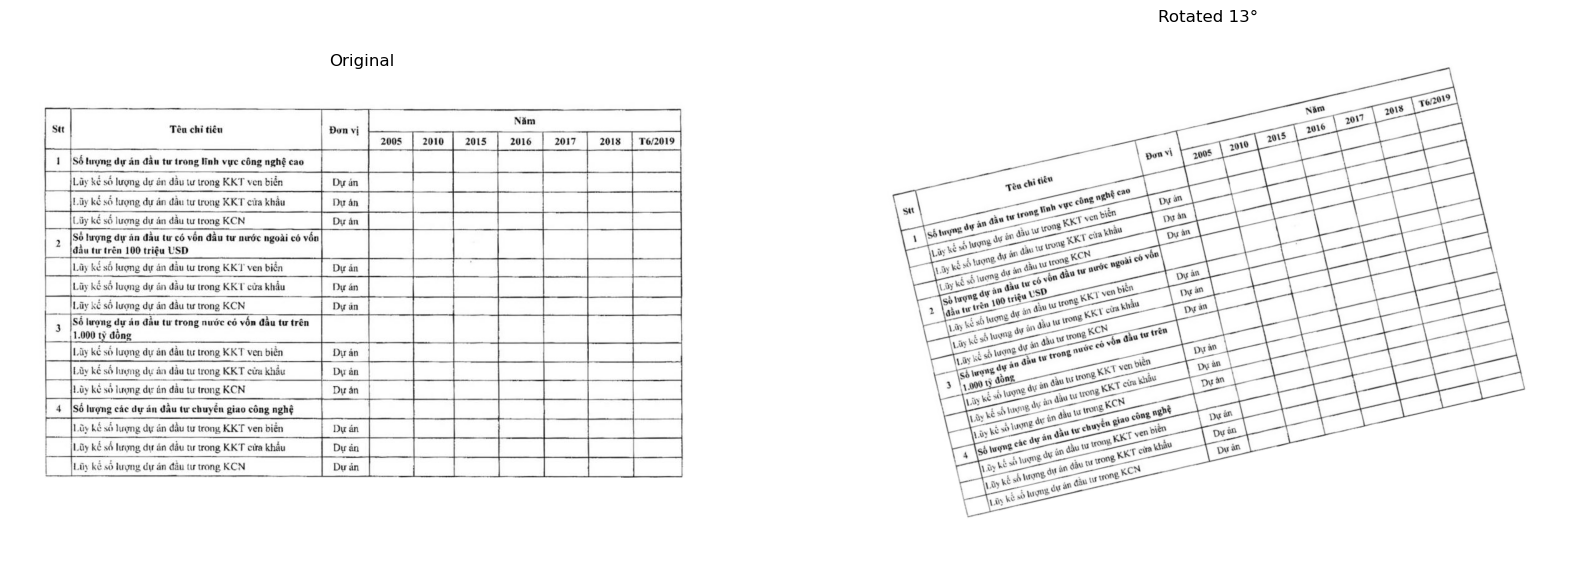

In [122]:
import cv2
import random
import numpy as np
from matplotlib import pyplot as plt

def rotate_image(image, angle):
    # Xác định kích thước ảnh
    height, width = image.shape[:2]

    # Tính toán ma trận xoay
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
    
    # Tính toán kích thước mới của ảnh sau khi xoay
    cos = np.abs(rotation_matrix[0, 0])
    sin = np.abs(rotation_matrix[0, 1])
    new_width = int((height * sin) + (width * cos))
    new_height = int((height * cos) + (width * sin))
    
    # Cập nhật ma trận xoay để điều chỉnh kích thước ảnh
    rotation_matrix[0, 2] += (new_width / 2) - (width / 2)
    rotation_matrix[1, 2] += (new_height / 2) - (height / 2)
    
    # Thực hiện xoay và điều chỉnh kích thước ảnh
    rotated_image = cv2.warpAffine(image, rotation_matrix, (new_width, new_height), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
    return rotated_image

image = cv2.imread("sample/vn1.jpg")
angle = random.randint(-30, 30)
rotated_image = rotate_image(image, angle)
# thiết lập kích thước hiển thị ảnh
plt.figure(figsize=(10, 20))
# hiển thị ảnh gốc và ảnh đã xoay
display_images_with_labels([(image, "Original"), (rotated_image, f"Rotated {str(angle)}°")], (1, 2), show_axis=False)

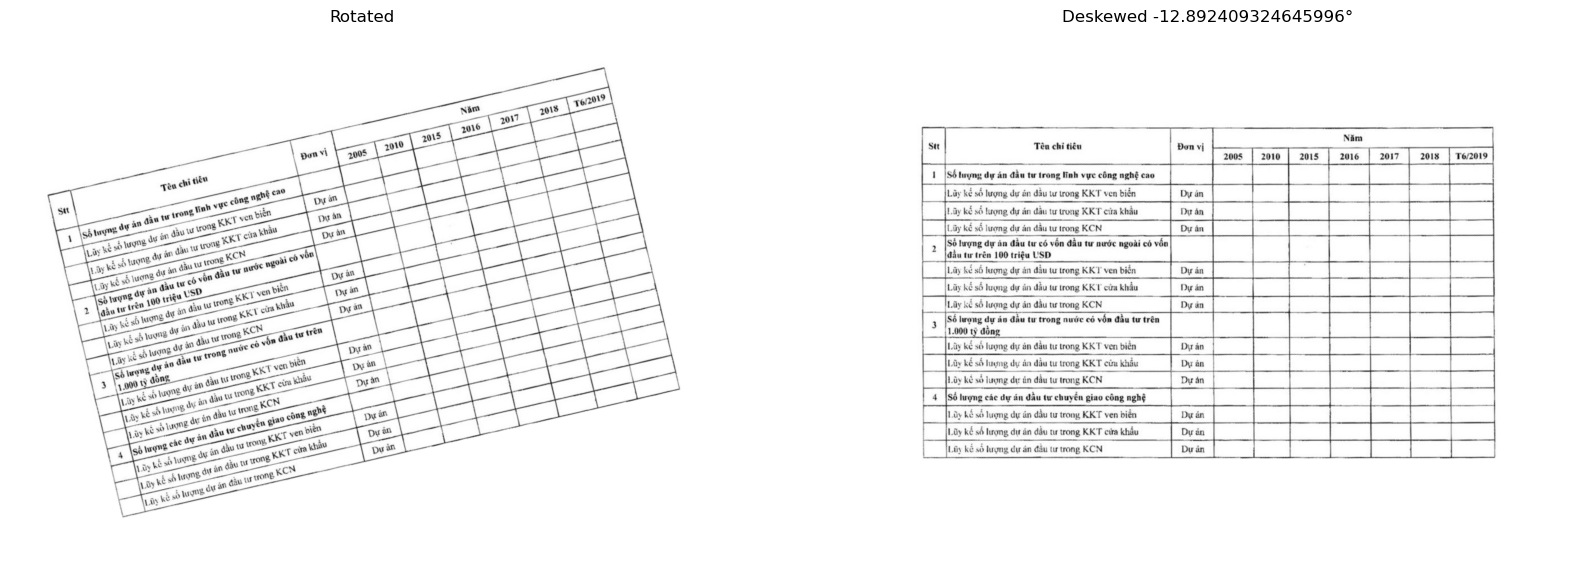

In [123]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def deskew_image(image):
    # Làm mờ ảnh
    blur_image = cv2.medianBlur(image, 5)

    # Chuyển đổi sang ảnh grayscale
    grayscale_image = cv2.bitwise_not(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

    # Xác định ngưỡng
    _, threshold_image = cv2.threshold(grayscale_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Tìm tọa độ các điểm ảnh khác 0
    coordinates = np.column_stack(np.where(threshold_image > 0))

    # Xác định góc xoay
    angle = cv2.minAreaRect(coordinates)[-1]
    if angle < -45:
        angle = -(90 + angle)
    elif angle > 45:
        angle = 90 - angle
    else:
        angle = -angle

    # Xoay ảnh để chỉnh sửa góc nghiêng
    height, width = blur_image.shape[:2]
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    deskewed_image = cv2.warpAffine(image, rotation_matrix, (width, height), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return deskewed_image, angle

image_ok, calc_angle = deskew_image(rotated_image)
display_images_with_labels([(rotated_image, "Rotated"), (image_ok, f"Deskewed {str(calc_angle)}°")], (1, 2), show_axis=False)

In [180]:
def detect_lines(img_bin, fixkernel, detectkernel):
    image_0 = cv2.dilate(img_bin, fixkernel, iterations=2)
    image_1 = cv2.erode(image_0, detectkernel, iterations=3)
    result = cv2.dilate(image_1, detectkernel, iterations=4)    
    return result

def recognize_structure(img):
    outImag=[]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_height, img_width = img.shape
    # THRESH_OTSU là phương pháp tự động xác định ngưỡng dựa trên histogram của ảnh
    thresh, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU) 
    outImag.append((img_bin, 'invert'))

    # Giả sử bảng có tối đa 50 dòng và 50 cột
    kernel_len_ver = img_height // 50
    kernel_len_hor = img_width // 50
    # Defining a vertical kernel to detect all vertical lines of image
    ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len_ver)) 

    # Defining a horizontal kernel to detect all horizontal lines of image
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len_hor, 1))  

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
 
    vertical_lines = detect_lines(img_bin, kernel, ver_kernel)
    outImag.append((vertical_lines, 'vertical_lines'))
    
    horizontal_lines = detect_lines(img_bin, kernel, hor_kernel)
    outImag.append((horizontal_lines, 'horizontal_lines'))

    img_vh = cv2.bitwise_or(vertical_lines, horizontal_lines)
    outImag.append((img_vh, 'Combine'))
    
    img_vh = cv2.dilate(img_vh, kernel, iterations=1)
    outImag.append((img_vh, 'dilate'))

    return img_vh, outImag

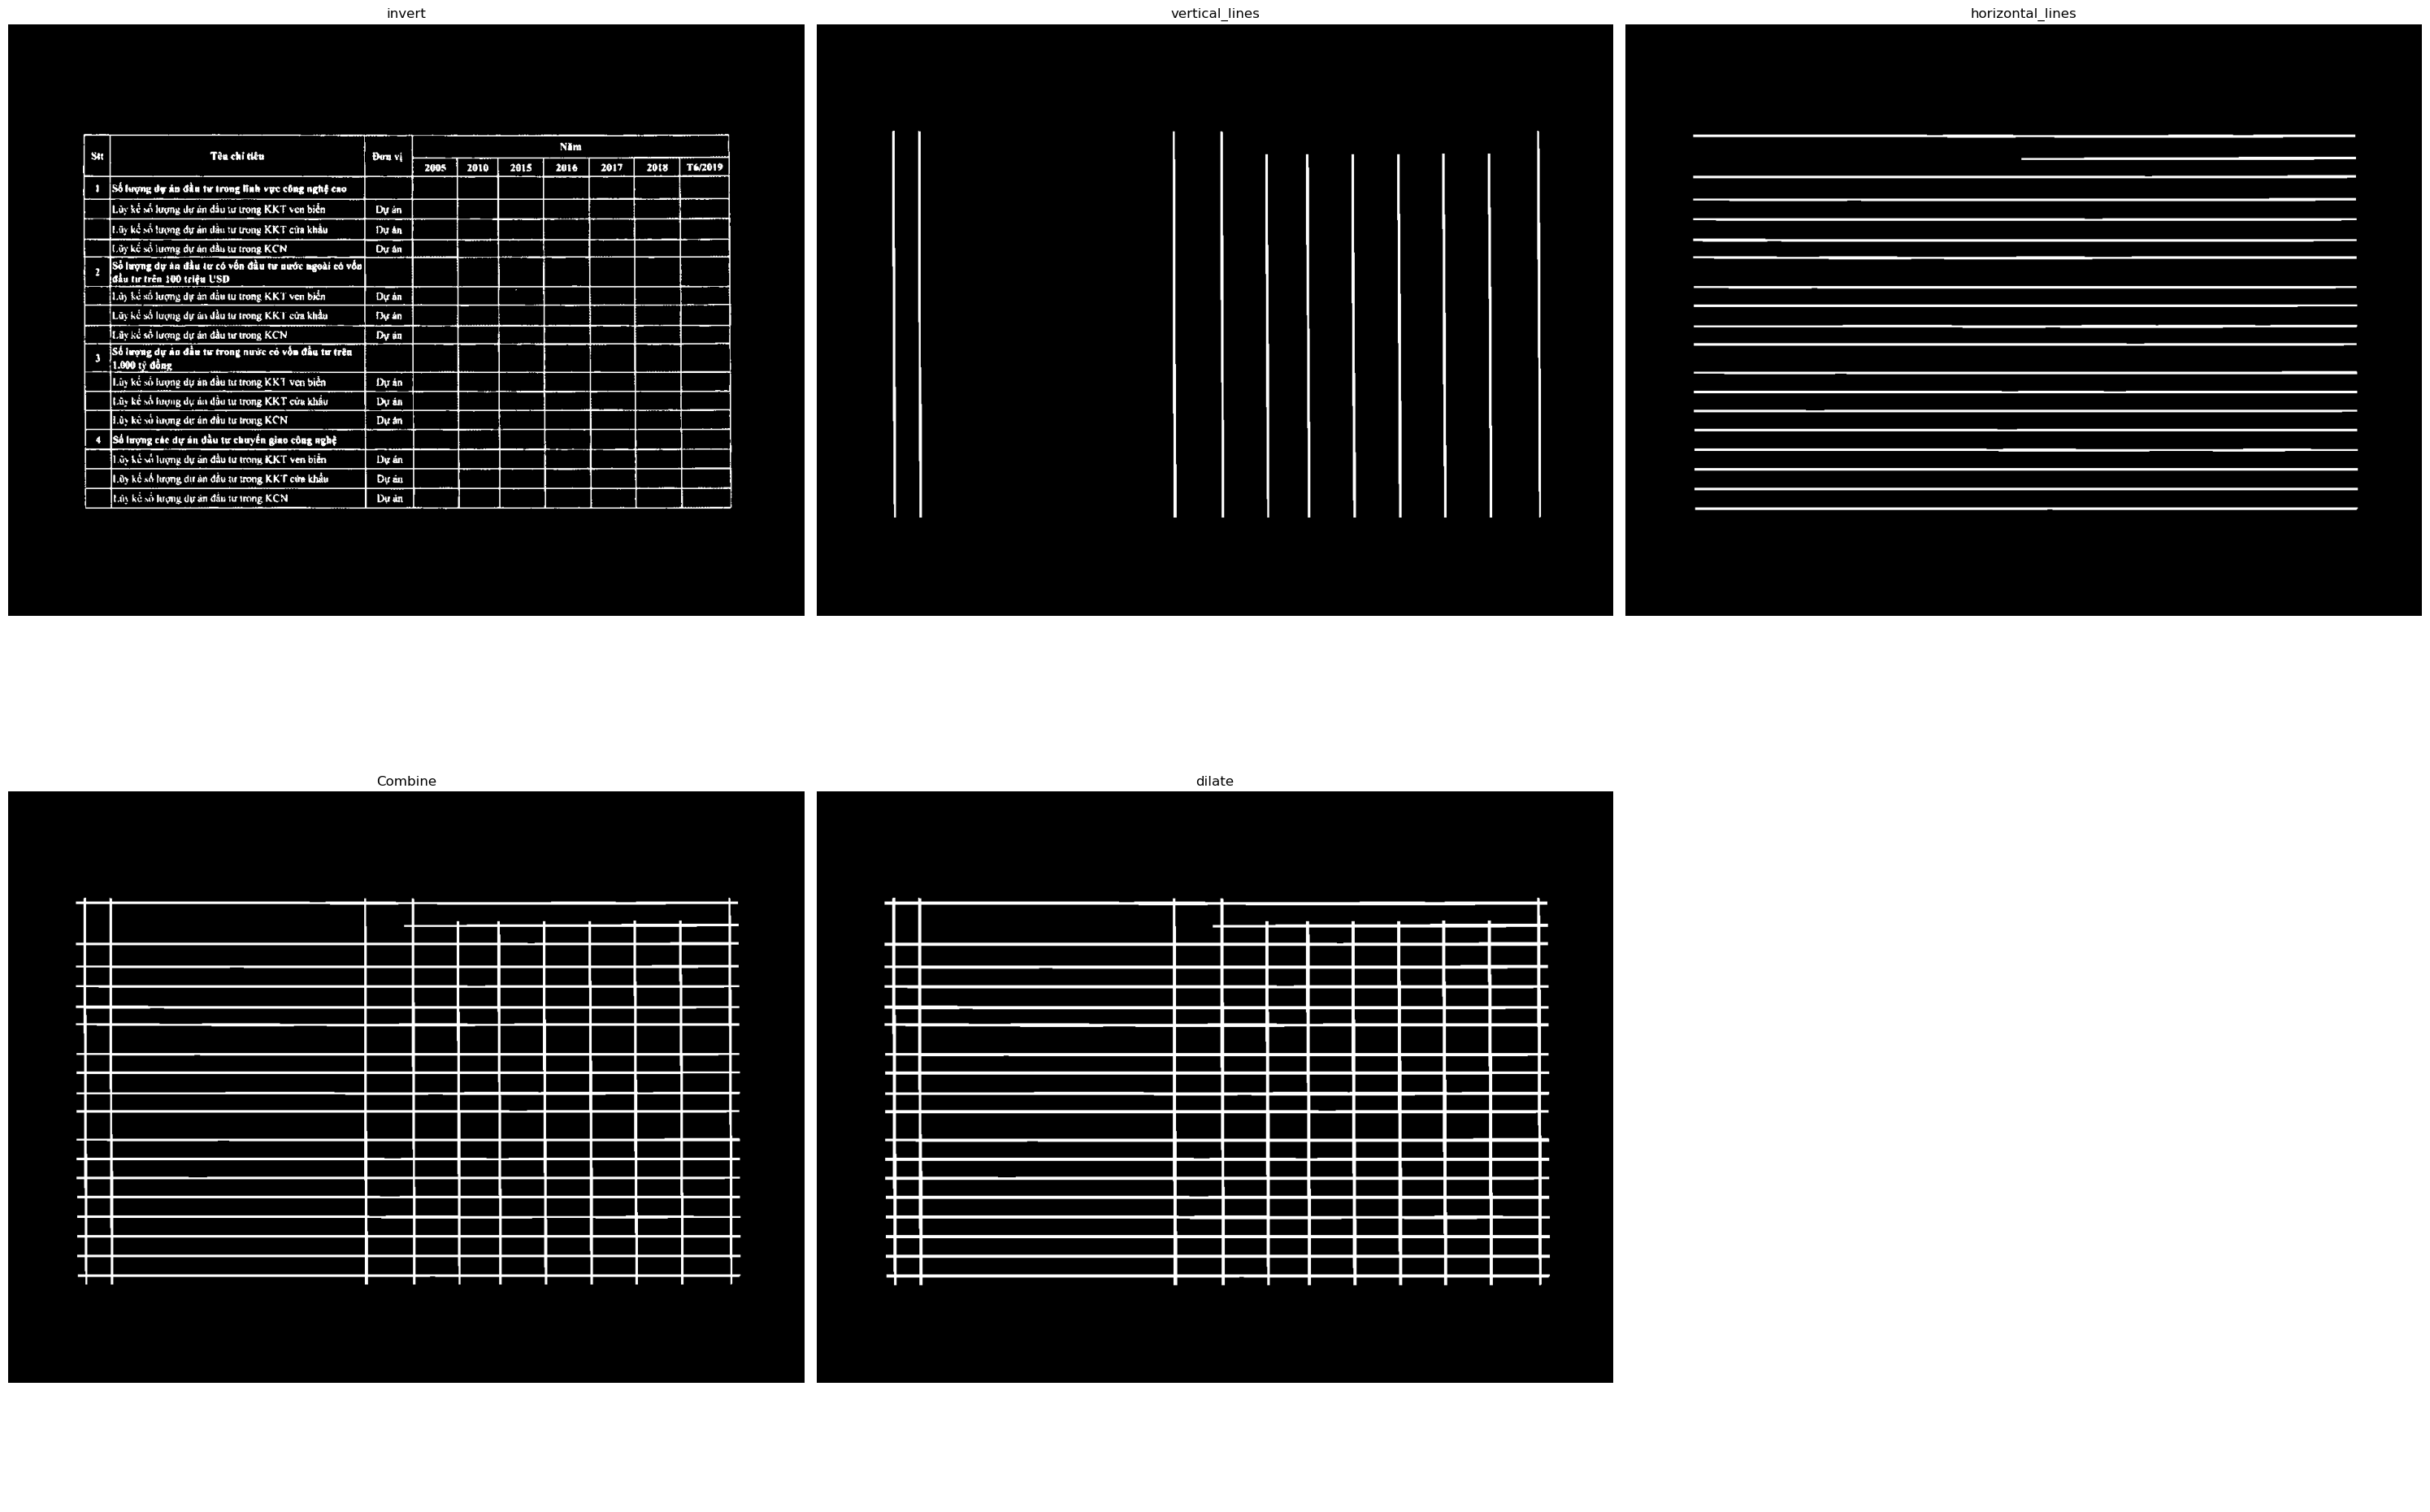

In [181]:
mask, outImag = recognize_structure(image_ok)
num_cols = 3
num_rows = len(outImag) // num_cols if len(outImag) % num_cols == 0 else len(outImag) // num_cols + 1
display_images_with_labels(outImag, (num_rows, num_cols), show_axis=False)

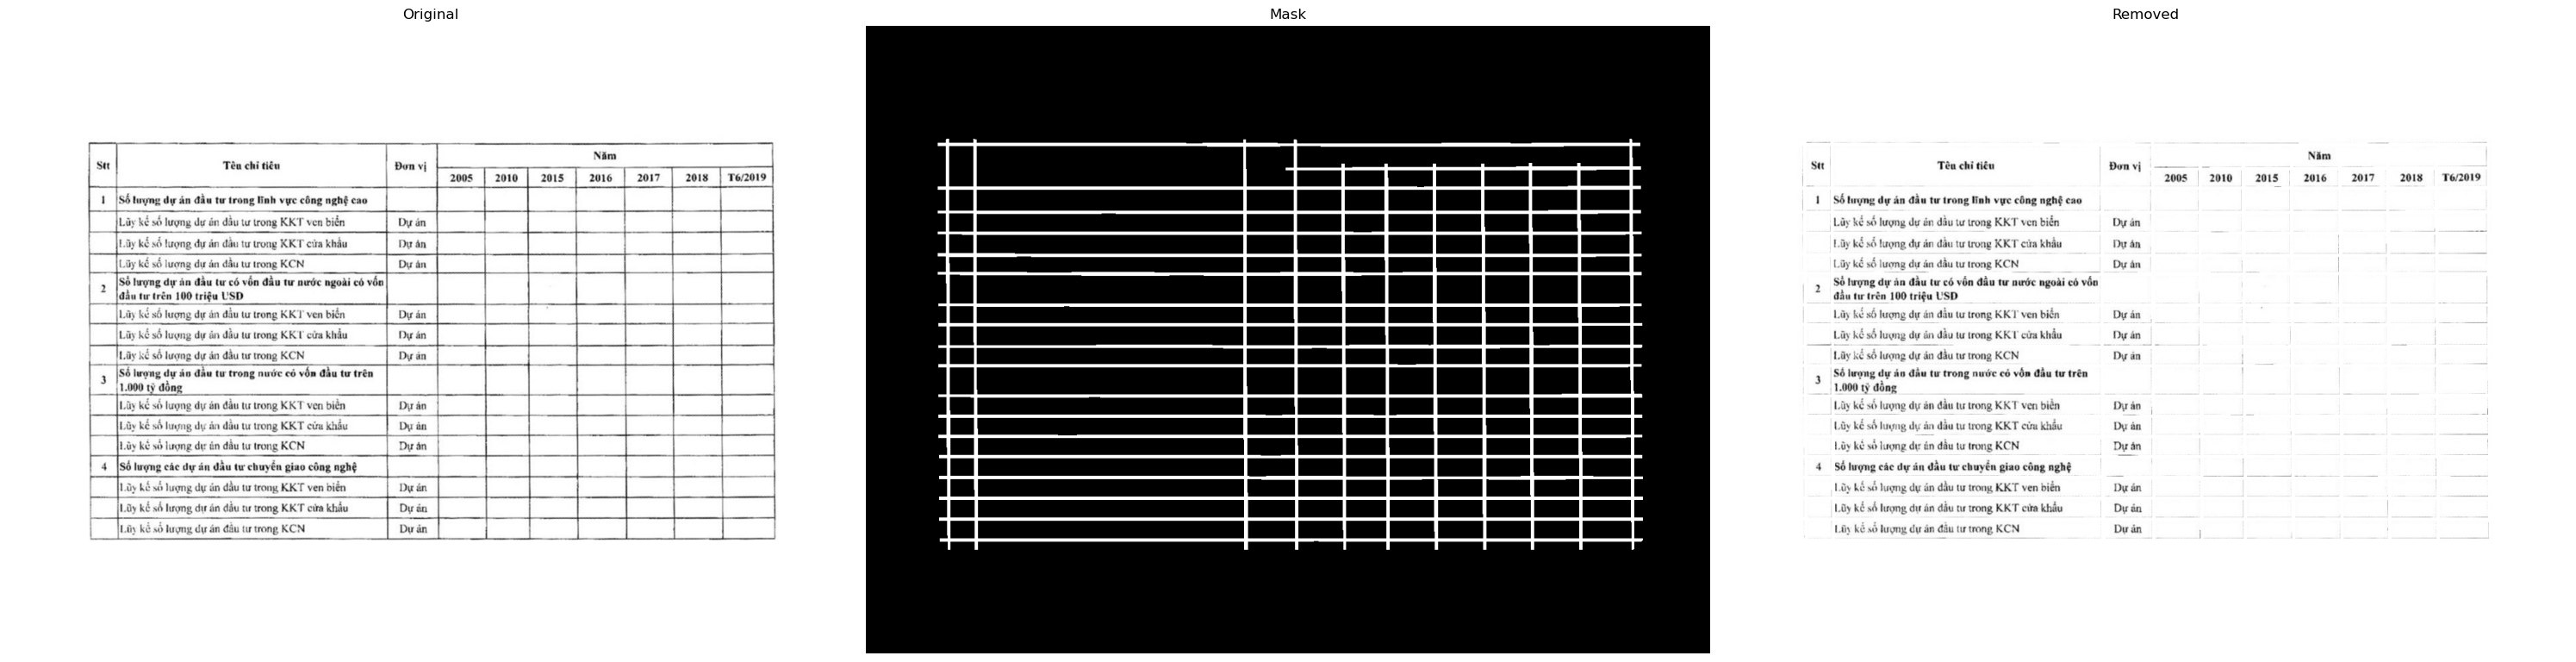

In [182]:
import cv2
import numpy as np

def remove_regions(image, mask):
    """
    Loại bỏ các vùng trong ảnh sử dụng mặt nạ.

    Tham số:
    - image: Ảnh gốc.
    - mask: Mặt nạ có kích thước giống với ảnh, với giá trị 0 ở các vùng cần loại bỏ và 1 ở các vùng khác.

    Trả về:
    - Ảnh đã loại bỏ các vùng cần loại bỏ.
    """
    masked_image = image.copy()
    masked_image[mask != 0] = [255, 255, 255]
    return masked_image

image_removed = remove_regions(image_ok, mask)
display_images_with_labels([(image_ok, "Original"), (mask,'Mask'), (image_removed, "Removed")], (1, 3), show_axis=False)

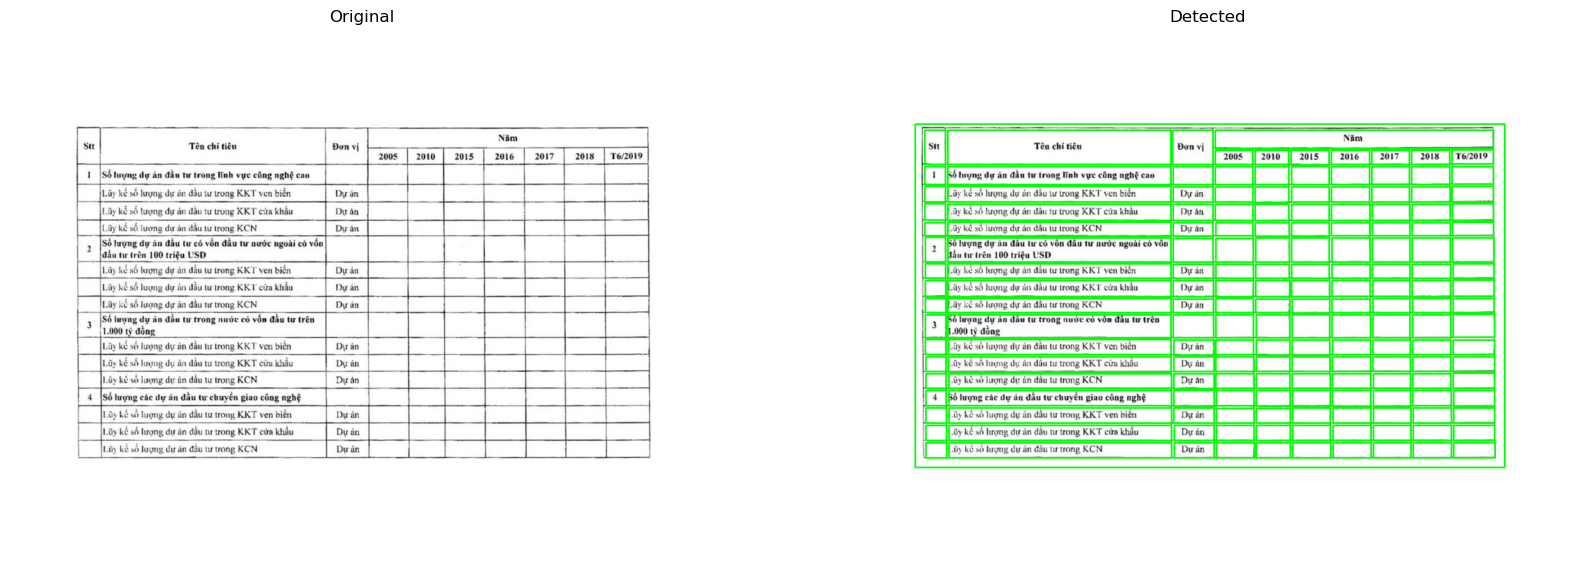

In [160]:
import cv2
import numpy as np

def detect_boxes(img_bin, image):
    """
    Phát hiện các ô trong ảnh nhị phân.

    Tham số:
    - img_bin: Ảnh nhị phân chứa mặt nạ các ô.
    - image: Ảnh gốc.

    Trả về:
    - Danh sách các ô đã phát hiện được. Mỗi ô là một list gồm 4 phần tử [x, y, w, h] tương ứng với tọa độ góc trên bên trái và kích thước của ô.
    """

    # Detect contours
    contours, hierarchy = cv2.findContours(img_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours from top to bottom
    def sort_contours(cnts, method="top-to-bottom"):
        reverse = False
        i = 0

        if method == "right-to-left" or method == "bottom-to-top":
            reverse = True

        if method == "top-to-bottom" or method == "bottom-to-top":
            i = 1

        boundingBoxes = [cv2.boundingRect(c) for c in cnts]
        cnts, boundingBoxes = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b: b[1][i], reverse=reverse))

        return cnts, boundingBoxes

    contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

    # Calculate mean height of boxes
    heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
    mean_height = np.mean(heights)

    # Create list to store boxes
    box = []

    # Filter and draw boxes
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if w < 0.9 * image.shape[1] and h < 0.9 * image.shape[0]:
            image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            box.append([x, y, w, h])

    # Sort boxes to rows and columns
    row = []
    column = []
    previous = box[0]

    for i, bbox in enumerate(box[1:]):
        if bbox[1] <= previous[1] + mean_height / 2:
            column.append(bbox)
            previous = bbox

            if i == len(box) - 2:
                row.append(column)
        else:
            row.append(column)
            column = []
            previous = bbox
            column.append(bbox)

    # Calculate maximum number of cells
    countcol = max(len(r) for r in row)

    # Retrieve the center of each column
    center = [int(r[j][0] + r[j][2] / 2) for r in row for j in range(len(r))]

    # Sort the boxes based on the distance to the column center
    finalboxes = []
    # for r in row:
    #     lis = [[] for _ in range(countcol)]
    #     for bbox in r:
    #         diff = abs(center - (bbox[0] + bbox[2] / 4))
    #         minimum = min(diff)
    #         indexing = list(diff).index(minimum)
    #         lis[indexing].append(bbox)
    #     finalboxes.append(lis)

    return finalboxes, image

boxes, draw_img = detect_boxes(outImag[-1][0], image_ok.copy())
display_images_with_labels([(image_ok, "Original"), (draw_img, "Detected")], (1, 2), show_axis=False)